In [2]:
from sac import SAC
from env import TradingEnvironment
import torch
import argparse
import datetime
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import yaml
import os
import tqdm
import wandb
import sys
import random
import json
import re

# from main import Trainer
# with open('SAC_config.yaml', 'r') as f:
#     config = yaml.load(f, Loader=yaml.FullLoader)
def seed_everything(seed):
    if seed > 0:
        random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        np.random.seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False  
        os.environ["PYTHONHASHSEED"] = str(seed)

def extract_configuration(log_file):
    config_pattern = r'Configuration is:\s+({.*?})\s+Episode'
    with open(log_file, 'r') as file:
        log_content = file.read()
        match = re.search(config_pattern, log_content, re.DOTALL)
        if match:
            config_str = match.group(1)
            config_json = json.loads(config_str)
            return config_json
        else:
            print(f"No configuration found in {log_file}")
            return None

def extract_from_specific_log(logs_dir, log_filename):
    log_path = os.path.join(logs_dir, log_filename)
    if os.path.exists(log_path) and log_path.endswith(".log"):
        config = extract_configuration(log_path)
        if config:
            print(f"Extracted configuration from {log_path}")
            return config
        else:
            print(f"No configuration found in {log_path}")
            return None
    else:
        print(f"Log file {log_filename} does not exist in {logs_dir}")
        return None

# 예제 사용법
logs_dir = '../res/SAC/log/'
log_filename = 'logging_42_SAC_Sharpe-test.log'  # 특정 로그 파일 이름으로 변경

config = extract_from_specific_log(logs_dir, log_filename)
batch_size = 1024 # config['batch_size']
start_steps = config['start_steps']
n_steps = config['n_steps']
seed = config['seed']
replay_size = config['replay_size']
agent_args = config['agent_args']
save_name = config['save_name']
env_args = config['env_args']
env_args['returns_data'] = '.'+ env_args['returns_data']
env_args['clusters_dir'] = '.'+ env_args['clusters_dir']
env_args['start_month'] = '1999-12'
env_args['end_month'] = '2022-08'
env_args['new_data'] = True

update_per_step = config['update_per_step']

seed_everything(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

sp = pd.read_csv('../data/sp500.csv', index_col=0)
cumulative_returns_df = pd.read_csv('../res/cumulative_returns.csv', index_col=0)
sp = sp.loc['2000-01':]
cumulative_returns_df = cumulative_returns_df.loc[env_args['start_month']:]
# starting with 0
cumulative_returns_df = cumulative_returns_df - cumulative_returns_df.iloc[0]
cumulative_returns = cumulative_returns_df.iloc[1:]

Log file logging_42_SAC_Sharpe-test.log does not exist in ../res/SAC/log/


TypeError: 'NoneType' object is not subscriptable

In [ ]:
env_args

{'returns_data': '../SAC/mom1_data_combined_adj_close.csv',
 'clusters_dir': '../res/batch_1024_n_bins_64_hidden_128_std_0.05_mask_0.01/predictions/50_characteristics_us',
 'start_month': '1999-12',
 'end_month': '2022-08',
 'reward_scale': 10,
 'num_inputs': 10,
 'hard_reward': 'Shapre',
 'new_data': True}

In [ ]:
env = TradingEnvironment(**env_args, sp500_data='../SAC/sp500.csv')
agent= SAC(**agent_args)

** Reward Scale: 10 **
New data is provided.
Start month: 1999-12, End month: 2022-08


/opt/conda/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Action Scale: tensor([1.2500, 0.3000], device='cuda:0')
Action Bias: tensor([1.2500, 0.5500], device='cuda:0')


In [4]:
def evaluate(agent, env, dir, name):
    agent.load_model(dir, name)
    state = env.reset()
    done = False
    total_reward = 0

    actions = []
    rewards = []
    portfolio_values = []
    while not done:
        action = agent.select_action(state, evaluate=True)
        next_state, reward, done = env.step(action)
        actions += [action]
        rewards += [reward/10]
        portfolio_values += [env.current_portfolio_value]
        total_reward += reward
        state = next_state
    
    print(f"Total reward: {total_reward}, {env.current_portfolio_value}")
    return total_reward, rewards, actions, portfolio_values

total_reward, rewards, actions, portfolio_values = evaluate(agent, env, '../res/SAC/models', save_name)
print(len(rewards))

Total reward: 79.24289149744317, 7.546942047375534
272


In [10]:
save_name

'SAC_Sharpe-test'

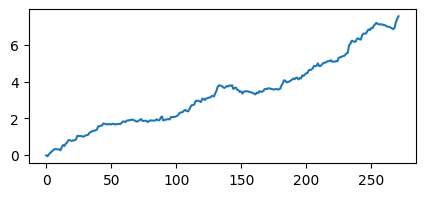

In [5]:
plt.plot(portfolio_values, figure=plt.figure(figsize=(5, 2)))

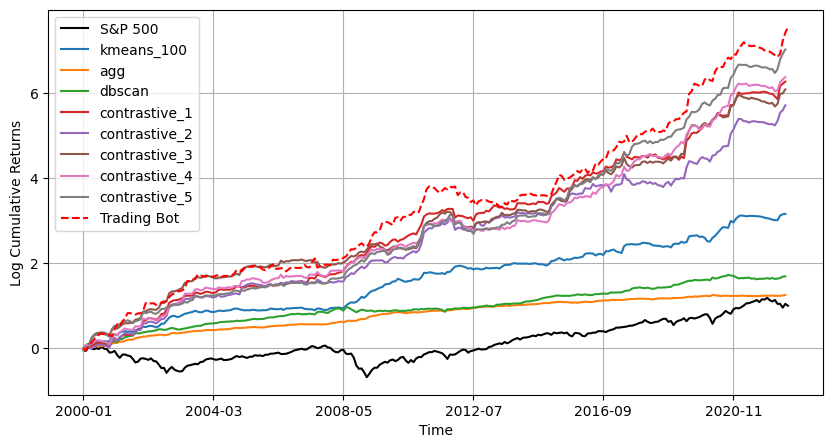

In [6]:
# Plot Everything
plt.figure(figsize=(10, 5))
np.log1p((sp.loc['2000-01':]['Monthly Returns']+1).cumprod()-1).plot(label='S&P 500', color='black', linestyle='solid')

for column in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[column], label=column)
plt.legend()
plt.xlabel('Time')
plt.ylabel('Log Cumulative Returns')

plt.plot(portfolio_values, label='Trading Bot', color='red', linestyle='dashed')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
cum_returns_series = pd.Series(portfolio_values)
returns_series = cum_returns_series.diff().fillna(cum_returns_series).tolist()
log_returns_list = cumulative_returns_df.diff()
log_returns_list.dropna(inplace=True)

In [8]:
def calculate_metrics(log_returns_list, target_return=0.0):
    # Convert log returns to simple returns
    simple_returns = np.exp(log_returns_list) - 1
    target_return_simple = np.exp(target_return) - 1

    # Max Drawdown Percent
    def calculate_mdd(log_returns_list):
        cum_log_return = np.cumsum(log_returns_list)
        cumulative_returns = np.exp(cum_log_return)
        max_cumulative_returns = pd.Series(cumulative_returns).cummax()
        drawdown = (cumulative_returns - max_cumulative_returns) / max_cumulative_returns
        mdd = drawdown.min()
        return mdd

    def calculate_sortino_ratio(returns, target_return=0):
        expected_return = np.mean(returns)
        downside_returns = returns[returns < target_return] - target_return
        downside_deviation = np.sqrt(np.mean(downside_returns**2))
        sortino_ratio = (expected_return - target_return) / downside_deviation if downside_deviation != 0 else np.nan
        return sortino_ratio, downside_deviation

    max_drawdown = calculate_mdd(log_returns_list)
    
    # Annual Return (using geometric mean)
    average_log_return = np.mean(log_returns_list)
    annual_return = np.exp(average_log_return * 12) - 1

    # Standard deviation (convert log returns to simple returns)
    monthly_std_simple = np.std(simple_returns, ddof=1)
    standard_deviation = monthly_std_simple * np.sqrt(12)
    
    # Sharpe Ratio
    sharpe_ratio = annual_return / standard_deviation if standard_deviation != 0 else np.nan

    # Sortino Ratio
    sortino_ratio, downside_deviation = calculate_sortino_ratio(simple_returns, target_return_simple)

    return sharpe_ratio, annual_return, standard_deviation, max_drawdown, sortino_ratio, downside_deviation

In [9]:
sharpe_ratio_kmeans, annual_return_kmeans, standard_deviation_kmeans, mdd_kmeans, sortiono_kmeans, down_kmeans = calculate_metrics(log_returns_list['kmeans_100'])
sharpe_ratio_agg, annual_return_agg, standard_deviation_agg, mdd_agg, sortino_agg, down_agg = calculate_metrics(log_returns_list['agg'])
sharpe_ratio_dbscan, annual_return_dbscan, standard_deviation_dbscan, mdd_dbscan, sortino_dbscan, down_dbscan = calculate_metrics(log_returns_list['dbscan'])

sharpe_ratio1, annual_return1, standard_deviation1, mdd1 , sortino1, down1 = calculate_metrics(log_returns_list['contrastive_1'])
sharpe_ratio2, annual_return2, standard_deviation2, mdd2 , sortino2, down2 = calculate_metrics(log_returns_list['contrastive_2'])
sharpe_ratio3, annual_return3, standard_deviation3, mdd3 , sortino3, down3 = calculate_metrics(log_returns_list['contrastive_3'])
sharpe_ratio4, annual_return4, standard_deviation4, mdd4 , sortino4, down4 = calculate_metrics(log_returns_list['contrastive_4'])
sharpe_ratio5, annual_return5, standard_deviation5, mdd5 , sortino5, down5 = calculate_metrics(log_returns_list['contrastive_5'])

sharpe_ratio_sac, annual_return_sac, standard_deviation_sac, mdd_sac, sortino_sac, down_sac = calculate_metrics(returns_series)

df = pd.DataFrame({'sharpe_ratio': [sharpe_ratio_kmeans, sharpe_ratio_agg, sharpe_ratio_dbscan, sharpe_ratio1, sharpe_ratio2,sharpe_ratio3, sharpe_ratio4, sharpe_ratio5, sharpe_ratio_sac],
                     'annual_return': [annual_return_kmeans, annual_return_agg, annual_return_dbscan, annual_return1, annual_return2,annual_return3, annual_return4, annual_return5, annual_return_sac],
                     'standard_deviation': [standard_deviation_kmeans, standard_deviation_agg, standard_deviation_dbscan, standard_deviation1, standard_deviation2, standard_deviation3, standard_deviation4, standard_deviation5, standard_deviation_sac],
                     'sortino_ratio': [sortiono_kmeans,sortino_agg, sortino_dbscan, sortino1, sortino2, sortino3, sortino4, sortino5, sortino_sac],
                    'max_drawdown': [mdd_kmeans, mdd_agg, mdd_dbscan, mdd1, mdd2, mdd3, mdd4, mdd5, mdd_sac],
                    'downside_deviation': [down_kmeans, down_agg,down_dbscan , down1, down2, down3, down4, down5, down_sac]},
                    index=['kmeans', 'agg', 'dbscan','cluster1','cluster2', 'cluster3', 'cluster4', 'cluster5', 'sac'])
# best sharpe ratio
print(df.idxmax())
df.T

sharpe_ratio          agg
annual_return         sac
standard_deviation    sac
sortino_ratio         agg
max_drawdown          agg
downside_deviation    sac
dtype: object


,kmeans,agg,dbscan,cluster1,cluster2,cluster3,cluster4,cluster5,sac
sharpe_ratio,1.250009,1.981105,1.272735,1.392196,1.288842,1.313795,1.576789,1.701498,1.457154
annual_return,0.149758,0.056594,0.077329,0.319812,0.287620,0.309105,0.326185,0.364676,0.395082
standard_deviation,0.119806,0.028567,0.060758,0.229718,0.223162,0.235276,0.206866,0.214326,0.271133
sortino_ratio,0.654088,0.817889,0.449255,0.688191,0.628947,0.633082,0.770176,0.731639,0.662401
max_drawdown,-0.136096,-0.028596,-0.110713,-0.244669,-0.262093,-0.315727,-0.248258,-0.360880,-0.390219
downside_deviation,0.018753,0.005663,0.014195,0.036845,0.036894,0.039139,0.033063,0.038315,0.046700
